# Imports

In [1]:
import sys
sys.path.insert(1, '../')
from genesis import *

C:\Users\vin_s\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
universe = [x for x in G10_FX if x != "USDCHF"]
total_returns = total_returns_usd[universe]
spot_returns = spot_returns_usd[universe]
carry_returns = carry_returns_usd[universe]

# Settings

In [3]:
settings = Settings(start_date = "2000-01-01", end_date = "2021-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=126, rebalance_period="daily",
             sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=126,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=252)

# Other Data

In [4]:
raw_ppp = pd.read_csv("../../Dymon/Code Data/PPP_OECD.csv")
unmelt_ppp = raw_ppp.pivot_table(index=['Year'], columns='LOCATION')['Value']
lagged_ppp = unmelt_ppp.shift(3)
lagged_ppp.index = [datetime.strptime(str(x), "%Y") for x in lagged_ppp.index]
lagged_ppp.columns = ["USDAUD", "USDCAD", "USDCHF", "USDCNH", "USDEUR", "USDGBP", 
                      "USDHKD", "USDIDR", "USDINR", "USDJPY", "USDKRW", 
                      "USDNOK", "USDNZD", "USDSGD", "USDSEK"]
clean_ppp = lagged_ppp.pipe(fill_date, True)

# Data integrity

# Signal

In [5]:
sig = (spot_price_usd[universe] - clean_ppp[universe])/clean_ppp[universe]
sig = sig.pipe(omit_leading_na, "any").pipe(omit_trailing_na).pipe(high_minus_low, rank=True) * -1

# Backtest Daily Rebal

In [6]:
daily_bt = Backtest(signal = sig, asset_returns = total_returns, tcost = abs(total_returns*0), settings = settings)
daily_bt.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [7]:
get_summary(daily_bt)

Returns   : 0.08329767008109298
Vol       : 0.10874010900006864
SR        : 0.7660252582700685
Max DD    : -19.21

C Returns : 0.08045674669169571
C SR      : 0.5501522189682599
C Max DD  : -17.96

Hit rate  : 0.51
W | N | L : 0.51 | 0.0 | 0.49
W/L Ratio : 1.04


In [8]:
get_returns_stats(daily_bt.asset_rtn, daily_bt.wts)

,USDAUD,USDCAD,USDEUR,USDGBP,USDJPY,USDNZD,USDSEK,USDNOK
annualized_return,1.870959,2.169577,-0.075123,0.524963,0.78487,1.696336,0.54595,1.079425
sharpe,0.543931,0.60157,-0.011868,0.115872,0.139434,0.452185,0.178945,0.113957
dollar_sharpe,0.48784,0.562596,-0.049561,0.092524,0.107211,0.410141,0.169479,0.059947
trade_sharpe,0.52668,0.850913,-0.075491,-0.078089,-0.036646,0.437047,-0.005543,0.062509
long_sharpe,0.200523,-1.141136,-9.165151,0.272166,0.167614,-0.297846,-0.51106,0.062509
short_sharpe,0.924207,0.855913,-0.075485,-0.229105,-0.472547,0.627998,0.496011,NaN
sortino,0.280582,0.251997,-0.006142,0.057125,0.088213,0.192546,0.070027,0.074355
max_drawdown,-9.080439,-8.132898,-28.388695,-20.090598,-28.290215,-17.268617,-10.616,-58.344153
max_drawdown_start,2016-02-02,2004-11-25,2013-02-01,2018-04-16,2013-10-07,2008-03-13,2006-03-07,2020-03-20
max_drawdown_end,2017-09-08,2005-05-16,2020-03-20,2019-08-09,2015-06-05,2009-03-02,2008-04-22,2021-04-28


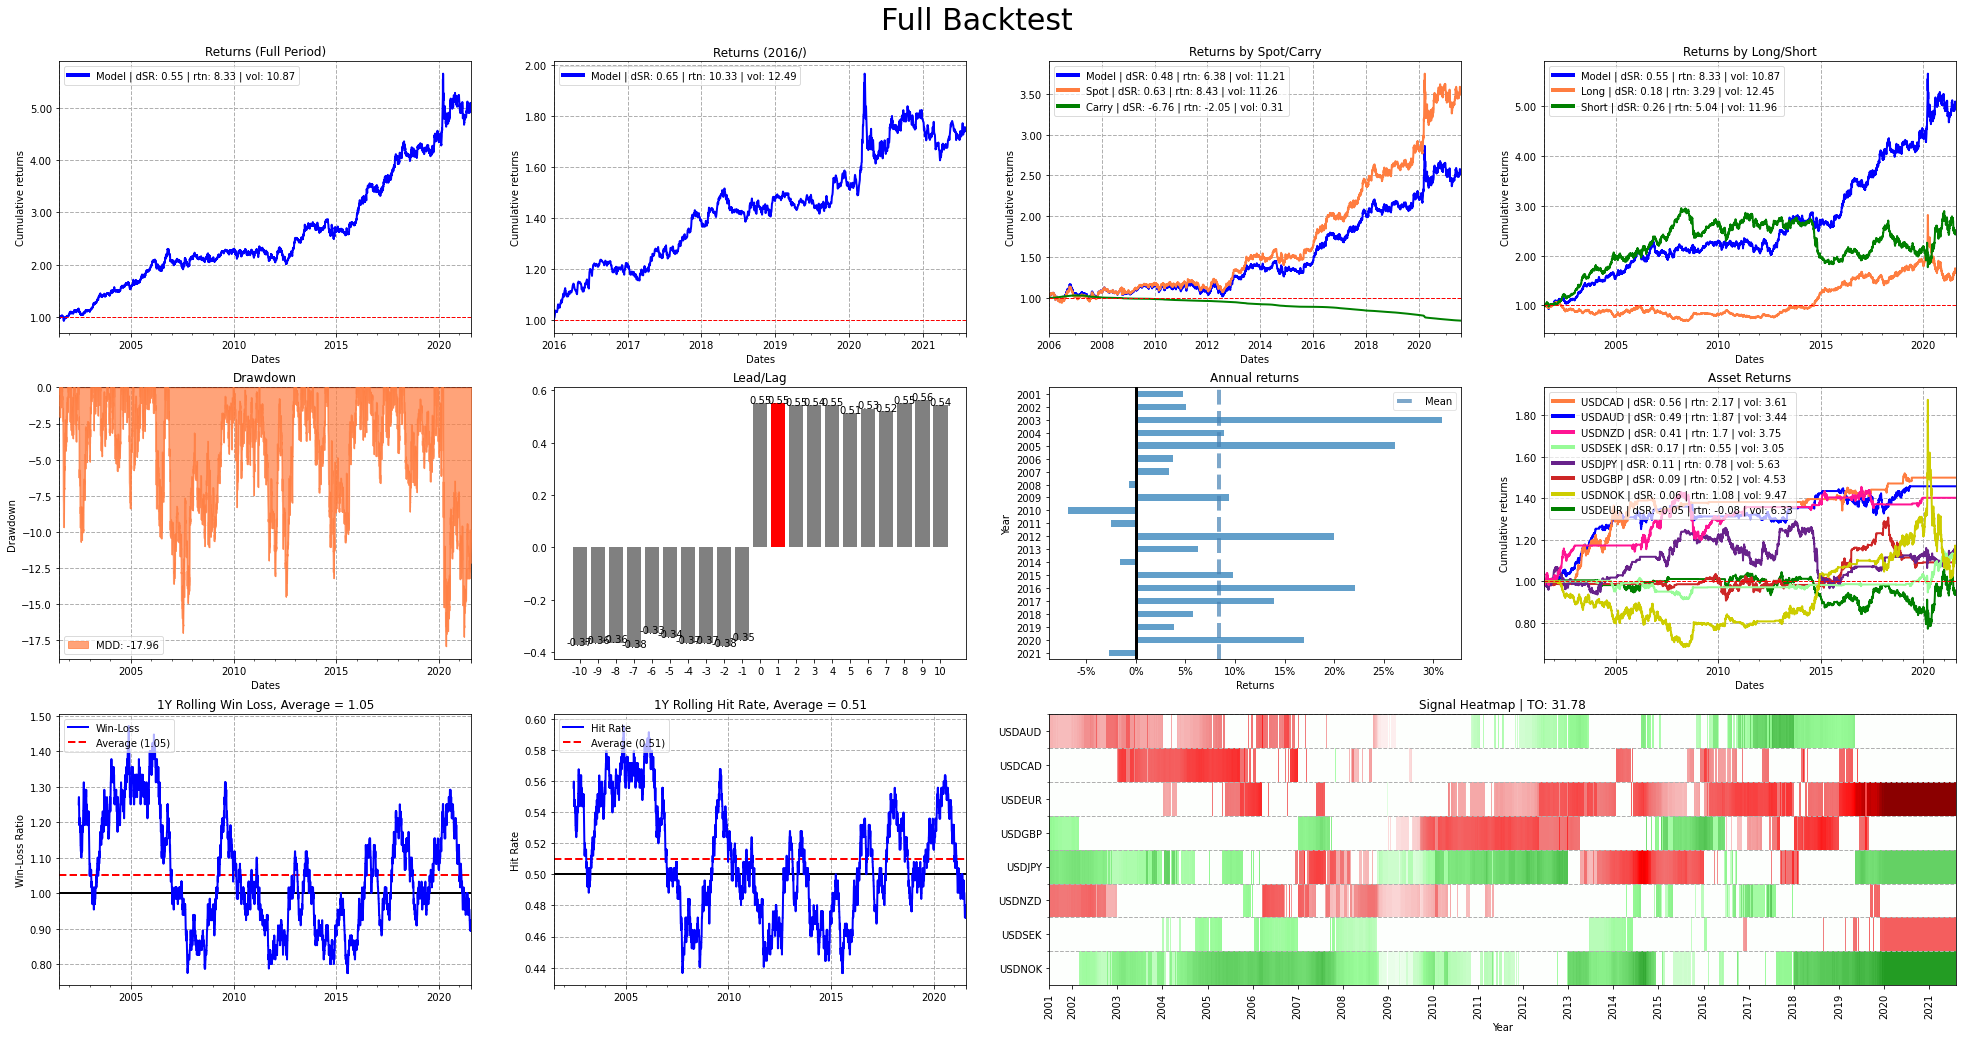

In [9]:
plot_bt(daily_bt, second_p="2016")

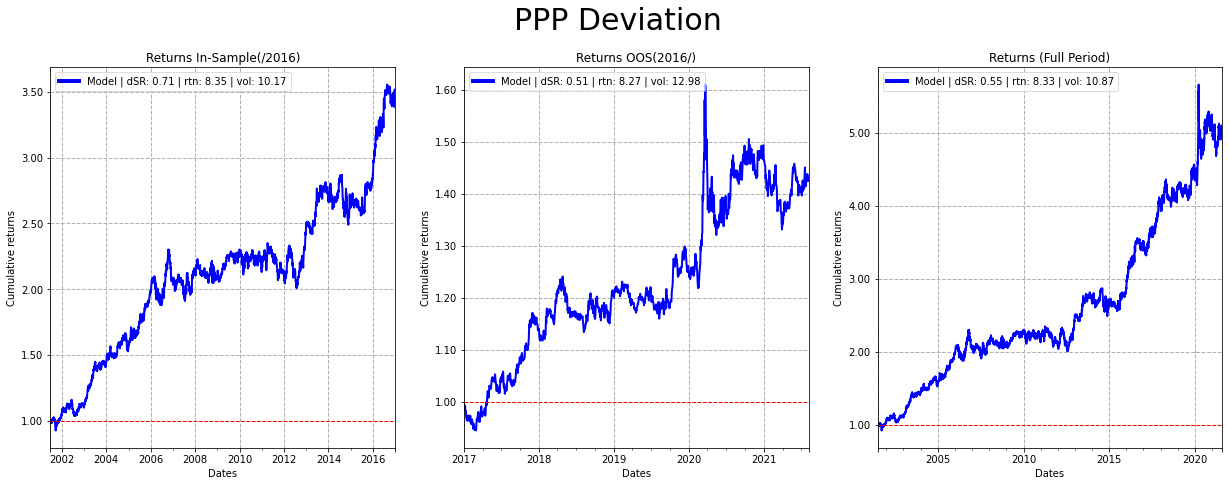

In [10]:
gs = GridSpec(nrows = 1, ncols = 3)
fig = plt.figure(figsize=(21, 7))
fig.suptitle(t="PPP Deviation", fontsize=30, y=1)

fig.add_subplot(gs[0]).set_label(gen_plot_rtn(daily_bt.model_rtn[:"2016"], main = "Returns In-Sample(/2016)", compound=True))
fig.add_subplot(gs[1]).set_label(gen_plot_rtn(daily_bt.model_rtn["2017":], main = "Returns OOS(2016/)", compound=True))
fig.add_subplot(gs[2]).set_label(gen_plot_rtn(daily_bt.model_rtn, main = "Returns (Full Period)", compound=True))

# PPP lag sensitivity

In [11]:
raw_ppp = pd.read_csv("../../Dymon/Code Data/PPP_OECD.csv")
unmelt_ppp = raw_ppp.pivot_table(index=['Year'], columns='LOCATION')['Value']
all_lagged_ppp = [unmelt_ppp.shift(x) for x in range(5)]
for data in all_lagged_ppp:
  data.index = [datetime.strptime(str(x), "%Y") for x in data.index]
  data.columns = ["USDAUD", "USDCAD", "USDCHF", "USDCNH", "USDEUR", "USDGBP", 
                      "USDHKD", "USDIDR", "USDINR", "USDJPY", "USDKRW", 
                      "USDNOK", "USDNZD", "USDSGD", "USDSEK"]

In [12]:
all_sigs = [(spot_price_usd[universe] - data.pipe(fill_date,True)[universe])/data.pipe(fill_date, True)[universe] for data in all_lagged_ppp]
all_sigs = [sig.pipe(omit_leading_na, "any").pipe(omit_trailing_na).pipe(high_minus_low, rank=True) * -1 for sig in all_sigs]

In [13]:
all_bts = [Backtest(signal = sig, 
                    asset_returns = total_returns, 
                    tcost = abs(total_returns*0), 
                    settings = settings) for sig in all_sigs]
for bt in all_bts:
  bt.run()

Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


<AxesSubplot:xlabel='Dates', ylabel='Cumulative returns'>

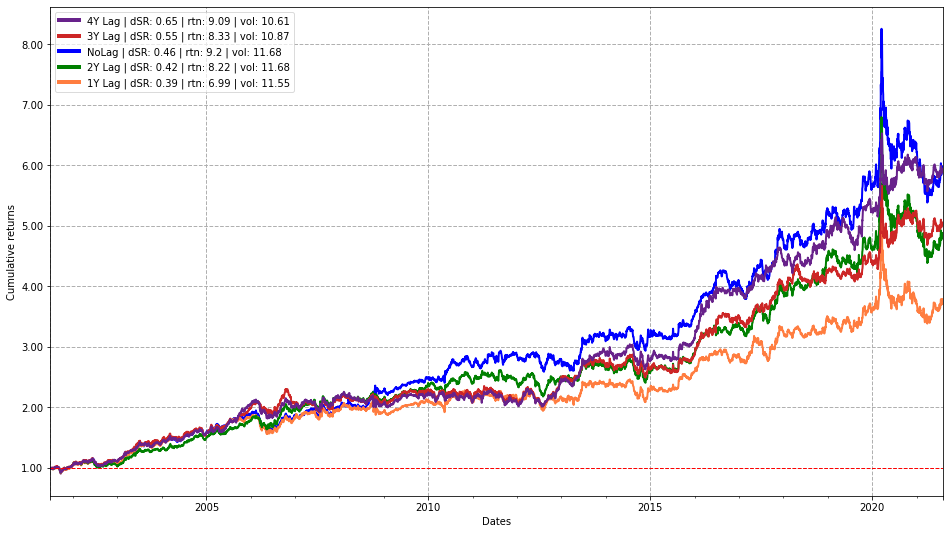

In [14]:
all_returns = pd.concat([x.model_rtn for x in all_bts], axis=1)
all_returns.columns = ["NoLag", "1Y Lag", "2Y Lag", "3Y Lag", "4Y Lag"]
gen_plot_rtn(all_returns, sr_sort=True)